# Naive Bayes — From Scratch

A **NumPy‑only** implementation of **Gaussian Naive Bayes** for binary
classification.

We will:

1. Generate a 2‑D synthetic dataset  
2. Derive the parameter estimates (class priors, per‑feature means & variances)  
3. Implement prediction using log‑probabilities  
4. Measure accuracy & visualise the decision boundary  

## 1. Quick Theory Recap

For a feature vector **x** with *D* dimensions and a class label  
\(C \in \{0,1,\dots,K-1\}\):

\[
P(C\,|\,\mathbf{x})
\;\propto\;
P(C)\,
\prod_{j=1}^{D} P(x_j\,|\,C)
\]

The **naive** assumption is that features \(x_j\) are **conditionally
independent** given the class.

For **Gaussian Naive Bayes** we model each feature with a univariate normal
distribution:

\[
P(x_j\,|\,C)
=
\mathcal{N}\bigl(x_j\,;\,\mu_{Cj},\,\sigma_{Cj}^2\bigr)
\]

During training we estimate, for every class *C* and feature *j*:

* Prior \(P(C) = N_C / N\)  
* Mean \(\mu_{Cj}\)  
* Variance \(\sigma_{Cj}^2\)  (use unbiased denominator \(N_C\))

At prediction time we use **log‑probabilities** to avoid underflow:

\[
\log P(C\,|\,\mathbf{x})
=
\log P(C)
\;+\;
\sum_{j=1}^{D}
\log
\mathcal{N}\bigl(x_j\,;\,\mu_{Cj},\,\sigma_{Cj}^2\bigr)
\]


### 2. Imports & synthetic data

In [1]:

import numpy as np
import matplotlib.pyplot as plt

# 2.1 Reproducibility
np.random.seed(0)

# 2.2 Two classes, independent Gaussian features
N_PER_CLASS = 150
# Class 0: centred at (-2,0)
mean0 = np.array([-2.0, 0.0])
std0  = np.array([1.0, 1.5])  # std-dev per feature

# Class 1: centred at (2,3)
mean1 = np.array([2.0, 3.0])
std1  = np.array([1.2, 1.0])

# Draw samples feature‑wise (diagonal covariance)
X0 = np.random.randn(N_PER_CLASS, 2) * std0 + mean0
X1 = np.random.randn(N_PER_CLASS, 2) * std1 + mean1

X = np.vstack([X0, X1])                 # shape (N,2)  with N = 300
y = np.hstack([np.zeros(N_PER_CLASS),   # class 0
               np.ones(N_PER_CLASS)])    # class 1
y = y.astype(int).reshape(-1, 1)

print(f'Dataset shapes -> X: {X.shape}, y: {y.shape}')


Dataset shapes -> X: (300, 2), y: (300, 1)


### 3. Helper functions

In [2]:
def fit_gaussian_nb(X, y):
    """
    Train Gaussian Naive Bayes classifier.
    Estimate class priors, means, and variances.

    Returns:
        priors  : class probabilities (shape: [K])
        means   : feature means per class (shape: [K, D])
        vars_   : feature variances per class (shape: [K, D])
    """
    classes = np.unique(y)       # Get all unique class labels
    K = len(classes)             # Number of classes
    D = X.shape[1]               # Number of features

    # Prepare space for priors, means, and variances
    priors = np.zeros(K)
    means  = np.zeros((K, D))
    vars_  = np.zeros((K, D))
    eps = 1e-9  # Small constant to prevent divide-by-zero

    # Loop through each class and compute stats
    for idx, c in enumerate(classes):
        X_c = X[y.ravel() == c]            # Get samples for class c
        priors[idx] = len(X_c) / len(X)    # Prior = class proportion
        means[idx]  = X_c.mean(axis=0)     # Mean of each feature
        vars_[idx]  = X_c.var(axis=0) + eps  # Variance of each feature (+eps)

    return priors, means, vars_

def gaussian_logpdf(x, mean, var):
    """
    Compute log of Gaussian probability density function (element-wise).
    This is used instead of raw probabilities to avoid underflow.

    Args:
        x     : input sample(s)
        mean  : mean of Gaussian
        var   : variance of Gaussian

    Returns:
        log probability for each feature
    """
    return -0.5 * (np.log(2 * np.pi * var) + ((x - mean) ** 2) / var)

def predict_gaussian_nb(X, priors, means, vars_):
    """
    Predict class labels for a batch of inputs using Gaussian Naive Bayes.

    Args:
        X      : input samples (shape: [N, D])
        priors : class priors (shape: [K])
        means  : per-class means (shape: [K, D])
        vars_  : per-class variances (shape: [K, D])

    Returns:
        Predicted labels (shape: [N, 1])
    """
    log_priors = np.log(priors)         # Convert priors to log scale
    K, D = means.shape                  # Number of classes and features
    N = X.shape[0]                      # Number of input samples
    log_probs = np.zeros((N, K))        # Log-probabilities for each class

    # Compute log-likelihood + log-prior for each class
    for k in range(K):
        # For class k: compute log-likelihood for each sample
        log_lik = gaussian_logpdf(X, means[k], vars_[k]).sum(axis=1)
        log_probs[:, k] = log_priors[k] + log_lik  # Total log-probability

    # Pick class with highest probability
    return np.argmax(log_probs, axis=1).reshape(-1, 1)

def accuracy(y_true, y_pred):
    """
    Calculate classification accuracy.

    Args:
        y_true : actual labels
        y_pred : predicted labels

    Returns:
        float: proportion of correct predictions
    """
    return np.mean(y_true == y_pred)


### 4. Train the model

In [3]:
# Train the Gaussian Naive Bayes model:
# This calculates class priors, means, and variances for each feature.
priors, means, vars_ = fit_gaussian_nb(X, y)

# Print the prior probabilities for each class
# These show how often each class appears in the data.
print('Class priors   :', priors)

# Print the mean of each feature for each class
# Each row corresponds to a class, each column to a feature.
print('Means per class:')
print(means)

# Print the variance of each feature for each class
# Variance shows how spread out the data is for each feature.
print('Variances per class:')
print(vars_)



Class priors   : [0.5 0.5]
Means per class:
[[-2.03166287  0.13008303]
 [ 1.83288061  2.86440489]]
Variances per class:
[[1.01690509 2.20251074]
 [1.47010028 0.97714232]]


### 5. Accuracy on training data

In [4]:
# Use the trained model to predict labels for the training data
y_pred = predict_gaussian_nb(X, priors, means, vars_)

# Calculate and print how many predictions match the true labels
print('Training accuracy:', accuracy(y, y_pred))


Training accuracy: 0.9733333333333334


### 6. Visual decision boundary

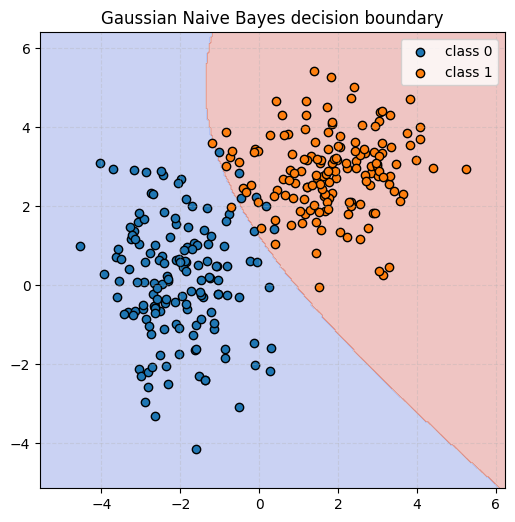

In [5]:
# ---------------------------------------------
# 📦 Build a grid of points over the 2D feature space
# This will let us predict the class at every location on the plot
# ---------------------------------------------

# Find the min and max values of the first feature (x-axis)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1

# Find the min and max values of the second feature (y-axis)
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

# Create a grid of 2D points across the entire space
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

# Flatten the grid into a list of (x, y) points
grid = np.c_[xx.ravel(), yy.ravel()]


# ---------------------------------------------
# 📊 Predict the class for each point in the grid
# This shows how the model would classify the whole feature space
# ---------------------------------------------

Z = predict_gaussian_nb(grid, priors, means, vars_)

# Reshape predictions back to match the 2D grid shape
Z = Z.reshape(xx.shape)

# ---------------------------------------------
# 🖼️ Plot the decision boundary and data points
# ---------------------------------------------

plt.figure(figsize=(6, 6))

# Draw filled contour map (decision regions)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')

# Plot training data (class 0 and class 1)
plt.scatter(X0[:, 0], X0[:, 1], label='class 0', edgecolor='k')
plt.scatter(X1[:, 0], X1[:, 1], label='class 1', edgecolor='k')


# Set plot limits and style
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.gca().set_aspect('equal')  # keep aspect ratio square
plt.legend()
plt.title('Gaussian Naive Bayes decision boundary')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


### 7. Confusion matrix

In [6]:
# Create a 2x2 matrix to count predictions:
# Rows = actual classes, Columns = predicted classes
conf = np.zeros((2, 2), dtype=int)

# Loop through all true and predicted labels
for true, pred in zip(y.ravel(), y_pred.ravel()):
    # Convert class labels to integers and update the count
    conf[int(true), int(pred)] += 1
    
# Print the confusion matrix
print('Confusion matrix:\n', conf)


Confusion matrix:
 [[144   6]
 [  2 148]]


### 8. Next steps

* **Multinomial / Bernoulli Naive Bayes** – great for discrete word counts and
  binary feature vectors.  
* **Shared variance (diagonal vs full)** – using the same variance across
  classes can improve robustness when data is scarce.  
* **Feature selection** – drop correlated or uninformative features to better
  satisfy the independence assumption.  
* **Laplace smoothing** – critical for discrete variants to avoid zero‑prob
  issues.  
* **Incremental updates** – priors, means, and variances can be updated online
  as new data arrives without retraining from scratch.
